# Day 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 붓꽃 데이터

다중 유형 분류

In [4]:
from sklearn.datasets import load_iris

iris = load_iris()
print(iris.data.shape)
# 유형 도수
pd.Series(iris.target).value_counts()

(150, 4)


0    50
1    50
2    50
Name: count, dtype: int64

In [50]:
from sklearn.linear_model import Perceptron

scores = {}

model = Perceptron(max_iter=20, eta0=0.1, shuffle=False)
model.fit(iris.data, iris.target)
scores['unshuffled'] = model.score(iris.data, iris.target)

model = Perceptron(max_iter=20, eta0=0.1, shuffle=True, random_state=3)
model.fit(iris.data, iris.target)
scores['shuffled'] = model.score(iris.data, iris.target)

print(pd.Series(scores).round(3))
pd.DataFrame(model.coef_, columns=iris.feature_names, index=iris.target_names).assign(
    bias=model.intercept_)

W = model.coef_; b = model.intercept_
outputs = iris.data @ W.T + b # X @ W.T + b
예측 = np.argmax(outputs, axis=1)
assert np.all(예측 == model.predict(iris.data))
print(f'정확도: {(예측 == iris.target).mean():.1%}')
pd.DataFrame(outputs, columns=iris.target_names).assign(예측=예측, 정답=iris.target).sample(5, random_state=0)

unshuffled    0.667
shuffled      0.967
dtype: float64
정확도: 96.7%


,setosa,versicolor,virginica,예측,정답
114,-2.834,-1.110,7.958,2,2
62,-1.544,3.598,-2.578,1,1
33,2.053,-2.402,-23.596,0,0
107,-3.294,2.977,6.381,2,2
7,1.446,-0.812,-19.152,0,0


In [45]:
A = np.arange(1, 5).reshape(2, 2)
B = np.arange(5, 9).reshape(2, 2)
C = A * B # 원소별 곱셈
D = A @ B # 행렬 곱셈

# 행렬곱
results = []
for 행 in A:
    for 열 in B.T:
        results.append(np.sum(행 * 열))
results = np.array(results).reshape(2, 2)
assert np.all(results == D) and np.all(np.dot(A, B) == D)

frame = pd.concat([pd.DataFrame(A), pd.DataFrame(B), pd.DataFrame(C), pd.DataFrame(D)], axis=1)
frame.columns = pd.MultiIndex.from_product([['A', 'B', 'C', 'D'], [0, 1]])
frame

A     B      C       D    
   0  1  0  1   0   1   0   1
0  1  2  5  6   5  12  19  22
1  3  4  7  8  21  32  43  50

## 신경망 순전파

In [57]:
random = np.random.default_rng(3)

xi = np.array([0.1, 0.2])

# layer 1
W1 = random.normal(size=(2, 3)) # 입력 2, 출력 3
b1 = random.normal(size=3) # 출력 3
# layer 2
W2 = random.normal(size=(3, 2)) # 입력 3, 출력 2
b2 = random.normal(size=2) # 출력 2
# layer 3
W3 = random.normal(size=(2, 1)) # 입력 2, 출력 1
b3 = random.normal(size=1) # 출력 1

# 순전파 (feed-forward)
z1 = xi @ W1 + b1
z2 = z1 @ W2 + b2
z3 = z2 @ W3 + b3

print(f'z1={z1.round(3)}')
print(f'z2={z2.round(3)}')
print(f'z3={z3.round(3)}')

z1=[-1.929 -0.578 -0.867]
z2=[-6.02   1.123]
z3=[2.312]


In [73]:
class 다중퍼셉트론:
    def __init__(self, 입력수, 출력수, 활성화=None, seed=None):
        random = np.random.default_rng(seed)
        self.W = random.normal(size=(입력수, 출력수))
        self.b = np.zeros(출력수, dtype=np.float32)
        self.활성화 = 활성화

    def __call__(self, x):
        z = x @ self.W + self.b
        if self.활성화 is not None:
            z = self.활성화(z)
        return z
    
class 신경망:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def __call__(self, x):
        """순전파"""
        for layer in self.layers:
            x = layer(x)
        return x
    
layer1 = 다중퍼셉트론(2, 3)
layer2 = 다중퍼셉트론(3, 2)
layer3 = 다중퍼셉트론(2, 1)

# 순전파
outputs = layer3(layer2(layer1(xi)))
print(f'outputs={outputs.round(3)}')

model = 신경망()
model.add(layer1)
model.add(layer2)
model.add(layer3)

assert np.all(outputs == model(xi))

outputs=[0.305]


In [72]:
import torch
import torch.nn as nn # neural network

X = torch.tensor([[0.1, 0.2]])
print(X.shape)

layer1 = nn.Linear(2, 3) # 입력 2, 출력 3
assert torch.allclose(layer1(X), X @ layer1.weight.T + layer1.bias)
layer2 = nn.Linear(3, 2) # 입력 3, 출력 2
layer3 = nn.Linear(2, 1) # 입력 2, 출력 1

outputs = layer3(layer2(layer1(X)))

model = nn.Sequential(layer1, layer2, layer3)
assert torch.allclose(outputs, model(X))

torch.Size([1, 2])


## 활성화

* 은닉층: 비선형 변환
* 출력층
    1. 회귀: 항등함수 (활성화 없음)
    1. 분류
        1. 이진 분류: sigmoid
        1. 다중 분류: softmax

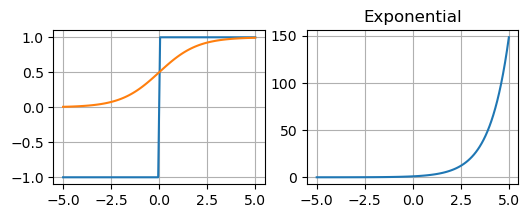

In [84]:
step = lambda x: np.where(x > 0, 1, -1)
sigmoid = lambda x: 1 / (1 + np.exp(-x))

xs = np.linspace(-5, 5, 100)

plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.plot(xs, step(xs))
plt.plot(xs, sigmoid(xs))
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(xs, np.exp(xs))
plt.title('Exponential')
plt.grid()
plt.show()

## 로지스틱 시그모이드

분류를 위한 확률 모델링 과정에서 개발 (1958)

In [ ]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
print(cancer.data.shape)
pd.Series(cancer.target).value_counts().rename({0: '악성', 1: '양성'})

(569, 30)


양성    357
악성    212
Name: count, dtype: int64

In [ ]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.preprocessing import StandardScaler

scores = {}
model_1 = Perceptron(max_iter=100, eta0=0.1, shuffle=True, random_state=3)
model_1.fit(cancer.data, cancer.target)
scores['Perceptron'] = model_1.score(cancer.data, cancer.target)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cancer.data)
# 데이터를 특성별로 표준화: 평균 0, 표준편차 1
assert np.allclose(scaled_data.mean(axis=0), 0) and np.allclose(scaled_data.std(axis=0), 1)
model_2 = LogisticRegression(max_iter=1000)
model_2.fit(scaled_data, cancer.target)
scores['LogisticRegression'] = model_2.score(scaled_data, cancer.target)

print(pd.Series(scores).round(3))

sample = pd.DataFrame(cancer.data).sample(random_state=7)
display(sample.round(3))

pred_1 = model_1.predict(sample)
pred_2 = model_2.predict(sample)
print(pred_1, pred_2)

Perceptron            0.912
LogisticRegression    0.988
dtype: float64


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
350,11.66,17.07,73.7,421.0,0.076,0.036,0.008,0.012,0.167,0.057,...,13.28,19.74,83.61,542.5,0.1,0.065,0.03,0.043,0.273,0.068


[1] [0]
